# Beispielskript zur Auslese von KOSTRA-Werten 
(DWD KOSTRA2010R, Stand Mai 2021)

Verwendete python-Module: numpy, matplotlib, ipyleaflet, ipywidgets, json, pandas


### Kurzanleitung
1.  Auf der interaktiven Karte die interessierende Zelle auswählen.
2.  Mit Hilfe der Zellen-ID werden die betreffenden Daten aus dem KOSTRA-Daten Numpy-Array herausgelöst, gepltottet und exportiert.

In [47]:
### Kartenanwendung

Map(center=[51, 8], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [43]:
from matplotlib import pyplot as plt
import numpy as np
#import ipyleaflet as ipyl
#import ipywidgets as ipyw
import json
import numpy as np
from ipywidgets import widgets, IntSlider, jslink, HTML, Layout,Label
from ipyleaflet import Map, GeoData,GeoJSON, basemaps, LayersControl,Popup, ScaleControl, FullScreenControl, WidgetControl,WMSLayer

# Map and label widgets
map = ipyl.Map(center=[51, 8], zoom=8)
label = Label(layout=Layout(width='100%'))
zoom_slider = IntSlider(description='Zoom level:', min=0, max=15, value=8)
jslink((zoom_slider, 'value'), (map, 'zoom'))
widgetControl = WidgetControl(widget=zoom_slider, position='topright')
map.add_control(widgetControl)
map.add_control(LayersControl())

wms_dtk = WMSLayer(
    name='NW_DTK_Sammeldienst_sw',
    url='https://www.wms.nrw.de/geobasis/wms_nw_dtk?',
    layers='nw_dtk_sw',
    format='image/png',
    transparent=True,
    attribution='nw_dtk_sw © geobasis nrw'
)


map.add_layer(wms_dtk)
map.add_control(ScaleControl(position='bottomleft'))
map.add_control(FullScreenControl(position='topright'))


# geojson layer with hover handler
with open('kostra.json') as f:
    data = json.load(f)
    

for feature in data['features']:
    feature['properties']['style'] = {
        'color': 'grey',
        'weight': 1,
        'fillColor': 'blue',
        'fillOpacity': 0.05
    }

layer = GeoJSON(name="DWD-KOSTRA2010R-Zellen",data=data, hover_style={'fillColor': 'red'})
map.add_layer(layer)

#def hover_handler(event=None, feature=None, id=None, properties=None):
#    label.value = str(properties['INDEX_RC'])
#layer.on_hover(hover_handler)
#map.add_layer(layer)
#ipyw.VBox([map, label])

def click_handler(type=None,event=None,feature=None,properties=None,id=None):
    label.value=str(properties['INDEX_RC'])    
    coords=(feature['geometry']['coordinates'][0])
    #print(np.array(coords))
    lo=(np.mean(coords,axis=0)[0])
    la=(np.mean(coords,axis=0)[1])
    text=str(feature['properties']['INDEX_RC'])
    #print(text)
    message = HTML(value=text)
    popup = Popup(location=(la, lo), child=message, close_button=True, auto_close=False, close_on_escape_key=False)
    map.add_layer(popup)
layer.on_click(click_handler)
ipyw.VBox([map, label])

56010


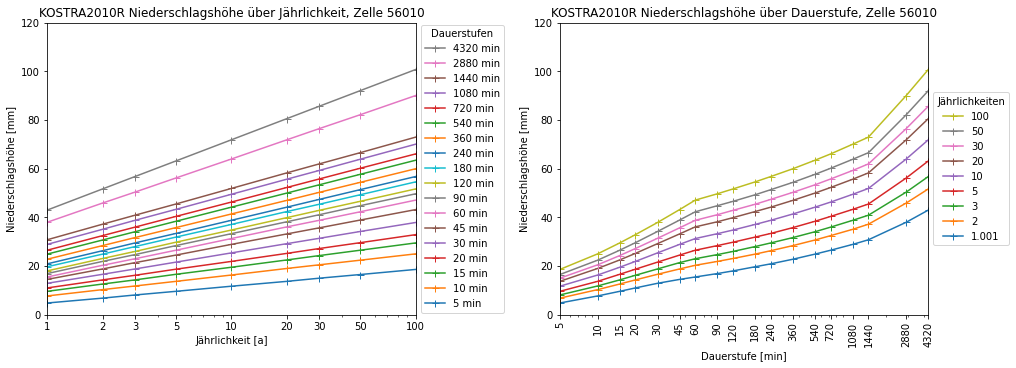

In [58]:
cell_id=int(label.value)
print(cell_id)
Tlist=[1.001,2,3,5,10,20,30,50,100] #Jährlichkeiten
Dlist=[5,10, 15, 20, 30, 45, 60, 90, 120, 180, 240, 360, 540,720, 1080, 1440, 2880, 4320] #Dauerstufen [min]

values=np.load('Input/KOSTRA2010R_Matrix_numpy.npy')#KOSTRA-Werte (Numpy-Array) laden
#print(values)
KOG=''
cell_ids=values[0,:,0]
cell_row=np.where(cell_id==cell_ids)[0]

import warnings
warnings.filterwarnings('ignore')
fig, (ax1, ax2) =plt.subplots(ncols=2,figsize=(14, 5),constrained_layout=True)
vals=values[:,cell_row,:]
#%
for d in range(len(Dlist)):
    ax1.plot(Tlist,vals[d,0,1:],label=str(Dlist[d])+' min',marker='+', linestyle='solid',linewidth=1.5, markersize=7)
    ax1.set_title('KOSTRA2010R'+KOG+ ' Niederschlagshöhe über Jährlichkeit, Zelle '+str(cell_id))
    ax1.set_xlim([0,100])
    ax1.set_ylim([0,120])
    ax1.set_xscale('log')
    ax1.xaxis.set_ticks(Tlist)
    ax1.set_xticklabels([str(round(i)) for i in Tlist])
    ax1.set_xlabel('Jährlichkeit [a]')
    ax1.set_ylabel('Niederschlagshöhe [mm]')
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #ax1.legend()
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles[::-1], labels[::-1], title='Dauerstufen', loc='center left',bbox_to_anchor=(1, 0.5))

    

for t in range(len(Tlist)):
    ax2.plot(Dlist,vals[:,0,t+1],label=str(Tlist[t]),marker='+',linestyle='solid',linewidth=1.5, markersize=7)
    ax2.set_title('KOSTRA2010R'+KOG+' Niederschlagshöhe über Dauerstufe, Zelle '+str(cell_id))
    ax2.set_xlim([0,max(Dlist)])
    ax2.set_ylim([0,120])
    ax2.set_xscale('log')
    ax2.xaxis.set_ticks(Dlist)
    ax2.set_xticklabels([str(round(i)) for i in Dlist],rotation='vertical')
    ax2.set_xlabel('Dauerstufe [min]')
    ax2.set_ylabel('Niederschlagshöhe [mm]')
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #ax1.legend()
    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles[::-1], labels[::-1], title='Jährlichkeiten', loc='center left',bbox_to_anchor=(1, 0.5))

plt.savefig('Output/KOSTRA2010R'+KOG+'_Regenhöhenlinien_'+str(cell_id)+'.png',dpi=300)


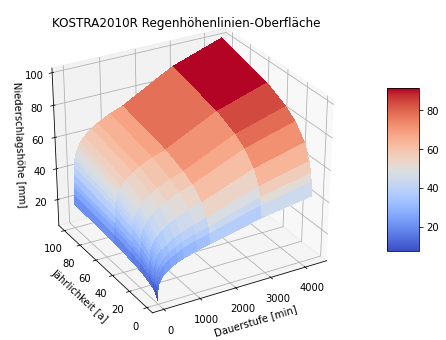

In [60]:
from matplotlib import cm
#3d plot
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(8,6))
X=Dlist
Y=Tlist
X, Y = np.meshgrid(X, Y)
Z=vals[:,0,1:]
Z=np.swapaxes(Z,1,0)
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title('KOSTRA2010R'+KOG+' Regenhöhenlinien-Oberfläche')
ax.set_xlabel('Dauerstufe [min]')
ax.set_ylabel('Jährlichkeit [a]')
ax.set_zlabel('Niederschlagshöhe [mm]')

ax.azim = 240
ax.dist = 10
ax.elev = 30
plt.savefig('Output/KOSTRA2010R'+KOG+'Regenhöhenoberfläche_'+str(cell_id)+'.png',dpi=300)

In [63]:
#Daten exportieren
import pandas as pd
tab=vals.transpose(0,2,1).reshape(-1,vals.shape[2])
df=pd.DataFrame(tab)
df.columns = ["INDEX_RC"]+['Tn_'+str(round(i)) for i in Tlist]
df['D_min']=Dlist
df.to_csv('output/KOSTRA2010R'+KOG+'_Zelle_'+str(cell_id)+'.csv',index=False)
#Binary data
np.save('output/KOSTRA2010R'+KOG+'_Matrix_numpy.npy', values)
print("Export beendet, Daten abrufbar im Export-Order 'output'")

Export beendet, Daten abrufbar im Export-Order 'output'
